[GitHub repository](https://github.com/LucieBonn/HAH913E-Physical-activity-00)

Who worked on this project? Lucie Bonnot

# Introduction

This notebook deals with the integration of ENMO (Euclidean Norm Minus One) over time intervals (epochs) of 10s, 30s, and 60s from raw accelerometer data. The goal is to visualize physical activity captured by an Axivity AX3 sensor worn on the non-dominant wrist.

# Dataset

The CSV file `0_z.csv` contains accelerometer data in the following format:

1. The first line is a comment: `# accelerometer data in g`.  
2. The second line contains the column headers: `t, x, y, z`.  
3. The remaining lines contain the data values, separated by commas.  

We skip the first line and let pandas use the second line as the header.  
This way, the data is loaded directly into four columns: `t`, `x`, `y`, and `z`, ready for further processing.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
import os
print(os.getcwd())

c:\Users\lucie\Documents\GitHub\MAM2ADMM-Series00-Git-LucieBonn\MAM2ADMM-Series00-Git-LucieBonn\MAM2ADMM-Series00-Git-LucieBonn\HAH913E-Physical-activity-00


In [21]:
def load_data():
    df = pd.read_csv('0_z.csv', skiprows=1)  # skip comment line
    return df

df = load_data()
df.head()

,t,x,y,z
0,0.00,-0.0938,-0.0156,0.9531
1,0.02,-0.0938,-0.0156,0.9531
2,0.04,-0.0938,-0.0156,0.9531
3,0.06,-0.0938,-0.0156,0.9531
4,0.08,-0.0938,-0.0156,0.9531


## Objective

Generate two visualizations:  
1. A bar plot of the ENMO integrated over varied epochs.  
2. A line plot of the raw ENMO over time.

# What is ENMO?

ENMO is calculated as the Euclidean norm of the x, y, z acceleration components minus 1g (Earth’s gravity). Negative values are set to zero because they do not represent physical activity.

In [22]:
def compute_enmo(df):
    norm = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    df['enmo'] = np.maximum(norm - 1, 0)
    return df

df = compute_enmo(df)
df.head()

,t,x,y,z,enmo
0,0.00,-0.0938,-0.0156,0.9531,0.0
1,0.02,-0.0938,-0.0156,0.9531,0.0
2,0.04,-0.0938,-0.0156,0.9531,0.0
3,0.06,-0.0938,-0.0156,0.9531,0.0
4,0.08,-0.0938,-0.0156,0.9531,0.0


Previously, Copilot suggested a formula that set negative ENMO values to zero. However, I prefer to keep these negative values to observe small fluctuations around 1g when the sensor is mostly stationary. This provides a more accurate view of very light or nearly static movements.

In [23]:
def compute_enmo(df):
    norm = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    df['enmo'] = norm - 1  # keep negative values
    return df
df = compute_enmo(df)
df.head()

,t,x,y,z,enmo
0,0.00,-0.0938,-0.0156,0.9531,-0.042168
1,0.02,-0.0938,-0.0156,0.9531,-0.042168
2,0.04,-0.0938,-0.0156,0.9531,-0.042168
3,0.06,-0.0938,-0.0156,0.9531,-0.042168
4,0.08,-0.0938,-0.0156,0.9531,-0.042168


## Integrated ENMO over Epochs

I group the ENMO values into epochs of a chosen length and calculate the mean.  
I then display a bar plot to visualize the intensity of physical activity.

In [24]:
def aggregate_enmo(df, epoch_length):
    df['epoch'] = (df['t'] // epoch_length).astype(int)
    aggregated = df.groupby('epoch')['enmo'].mean().reset_index()
    aggregated['time'] = aggregated['epoch'] * epoch_length / 60  # convert to minutes
    return aggregated

The formula suggested by Copilot did not yield the same values as those obtained by my professor. Therefore, I chose to use a summation approach to perform actual integration.

In [25]:
def aggregate_enmo_gmin(df, epoch_length):
    df['epoch'] = (df['t'] // epoch_length).astype(int)
    aggregated = df.groupby('epoch')['enmo'].sum().reset_index()
    aggregated['enmo_gmin'] = aggregated['enmo'] * (epoch_length / 60)  # correct factor
    aggregated['time_min'] = aggregated['epoch'] * epoch_length / 60
    return aggregated

## Combined Visualization for 10-Second Epochs

We display two plots in a single figure:  
1. A bar plot of the average ENMO per 10-second epoch  
2. A line plot of the raw ENMO over time  

This allows us to identify both sustained activity and short bursts.

In [26]:
aggregated_10s = aggregate_enmo_gmin(df, epoch_length=10)

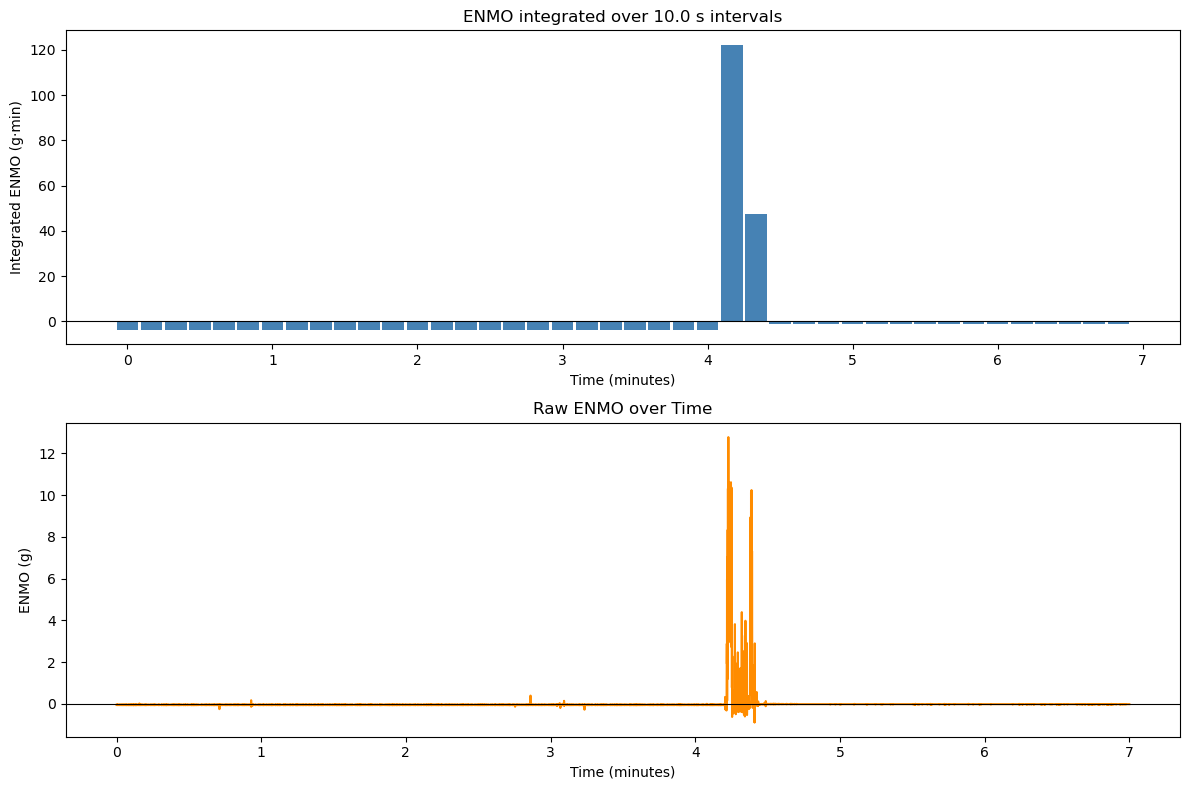

In [27]:
df['time_min'] = df['t'] / 60  # convert seconds to minutes
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Bar plot: ENMO aggregated
axs[0].bar(aggregated_10s['time_min'], aggregated_10s['enmo_gmin'], width=0.15, color='steelblue')
axs[0].set_title('ENMO integrated over 10.0 s intervals')
axs[0].set_ylabel('Integrated ENMO (g·min)')
axs[0].set_xlabel('Time (minutes)')
axs[0].axhline(0, color='black', linewidth=0.8)

# Line plot: raw ENMO
axs[1].plot(df['time_min'], df['enmo'], color='darkorange')
axs[1].set_title('Raw ENMO over Time')
axs[1].set_xlabel('Time (minutes)')
axs[1].set_ylabel('ENMO (g)')
axs[1].axhline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('enmo_epoch_10s.png')
plt.show()
